# This code will train the model and save weights  using a data generator

First Import libraries

In [1]:
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [3]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define our Data Generator and other functions to be used later

In [4]:
from Data_Gen import DataGenerator 

In [5]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [6]:
def gather_set_and_path(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(str(data_path+f))
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

Define the paths where images and segmentations are located. Gather into groups and arrange into a dictionary that can be split up for training, testing, and validation for the model

## Expected Dimmentions

Image: (512,512) range: 0:255

Label: (512,512) range: 0:1

In [7]:
data_path_1 = r"C:\Users\UAB\data\KU\data\\"
data_path_2 = r"C:\Users\UAB\data\Mayo\data\\"
data_path_3 = r"C:\Users\UAB\data\Emory\data\\"
data_path_4 = r"C:\Users\UAB\data\UAB\data\\"

images_1 = gather_set_and_path(data_path_1, '_M')
images_2 = gather_set_and_path(data_path_2, '_M')
images_3 = gather_set_and_path(data_path_3, '_M')
images_4 = gather_set_and_path(data_path_4, '_M')


images = images_1+images_2+images_3+images_4

print(len(images))



77885


In [8]:
print(len(images_1))
print(len(images_2))
print(len(images_3))
print(len(images_4))


26082
21037
23488
7278


C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_M.npy


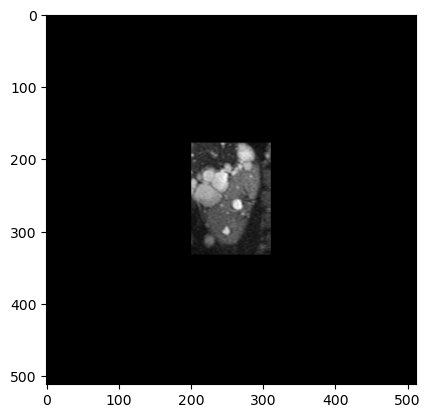

In [9]:
%matplotlib inline
print(images[-1500])
image = np.load(images[-1500])
plt.imshow(image, cmap='gray')
 


In [10]:
labels_1 = gather_set_and_path(data_path_1, '_K')
labels_2 = gather_set_and_path(data_path_2, '_K')
labels_3 = gather_set_and_path(data_path_3, '_K')
labels_4 = gather_set_and_path(data_path_4, '_K')

labels = labels_1 + labels_2 + labels_3 + labels_4
print(len(labels))


77885


In [11]:
test_img = np.load(images[100])
print(test_img.shape)
test_lab = np.load(labels[100])
print(test_lab.shape)


(512, 512)
(512, 512)


## Define Image and Label ID for data generator

Here the "test train split" will need to be replaced so we have the whole patient in one or the other"


In [12]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [13]:
print(len(labels))

77885


In [14]:
import os
img_name = os.path.basename(images[0])[0:11]
print(img_name)

KU_101934_0


## Image separation for entire patient in training or validation - use with single set of images


In [15]:
from sklearn.model_selection import train_test_split


id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:11]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [16]:
print(len(unique_ids))

350


In [17]:
train, val = train_test_split(unique_ids, train_size = 0.8)

In [18]:
print(len(train))
print(len(val))

280
70


In [19]:
print(train[0:2])

['KU_161547_2', 'KU_173203_0']


In [20]:
#use this when images do not contain filepath:
#train_list = [image for image in images if image[0:8] in train]
#val_list = [image for image in images if image[0:8] in val] 

In [21]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train):
        train_list.append(images[i])

In [22]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val):
        val_list.append(images[i])

In [23]:
print(len(train_list))
print(len(val_list))
print(len(train_list)+len(val_list))
print(len(images))

61505
16380
77885
77885


In [24]:
partition = {'train':train_list, 'validation':val_list}

In [25]:
print(len(train_list))
print(len(val_list))
print(len(train))
print(len(val))

61505
16380
280
70


## Use for crossfold validation:

In [15]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [11]:
train_sets = ['MA_', 'KU_', "EM_"]
val_sets = ["UB_"]

train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [12]:
print(train_list[100])

C:\Users\UAB\Kidney-Segmentation-Jupyter\data\\KU_101934_1_96_R_13_M.npy


In [13]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])


In [14]:
print(val_list[100])

C:\Users\UAB\data\UAB\data\\UB_419258_0_11_L_9_M.npy


In [15]:
partition = {'train':train_list, 'validation':val_list}
print(len(train_list))
print(len(val_list))

66273
1081


## Use for given excel file

In [16]:
import pandas as pd
df = pd.read_excel (r"C:\Users\UAB\Kidney-Segmentation-Jupyter\Data for AI development.xlsx", engine='openpyxl')

In [17]:
df = df.iloc[1: , 0:4]
df. columns=df. iloc[0] 

In [18]:
df2 = df.filter(regex='Validation')
df2 = df2.iloc[:,0].dropna()
val_csv_list = df2.values.tolist()
val_csv_list = val_csv_list[1:]

In [19]:
df3 = df.filter(regex='Training')
df3 = df3.iloc[:,0].dropna()
train_csv_list = df3.values.tolist()
train_csv_list = train_csv_list[1:]

In [20]:
print(len(train_csv_list))
print(train_csv_list[0])
print(len(val_csv_list))
print(val_csv_list[0])

151
439240L
19
419258L


In [21]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [22]:
id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:17]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [23]:
train_sets=[]
for i in range(len(train_csv_list)):
    phrase1 = train_csv_list[i][:-2]
    phrase2 = train_csv_list[i][-1]
    #print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                train_sets.append(name)
            else:
                continue
        else:
            continue

In [24]:
val_sets=[]
for i in range(len(val_csv_list)):
    phrase1 = val_csv_list[i][:-2]
    phrase2 = val_csv_list[i][-1]
    #print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                val_sets.append(name)
            else:
                continue
        else:
            continue

In [25]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])

In [26]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])

In [27]:
print(len(train_list))
print(len(val_list))
partition = {'train':train_list, 'validation':val_list}

60327
8516


# Create our data generators 

In [52]:
params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [26]:
from Data_Gen_Mask_PREDICTION import DataGeneratorK

In [27]:
params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 2,
          'shuffle': True,}
model = 'cyst_seg_80-10_split_35epoch.h5'
training_generator = DataGeneratorK(partition['train'], labels, **params)
validation_generator = DataGeneratorK(partition['validation'], labels, **params)

In [28]:
X,y = training_generator[8]
print(X.shape, y.shape)

X shape is  (32, 512, 512, 2)
load model complete
(32, 512, 512, 2)
successful kidney mask prediction
(32, 512, 512, 2) (32, 512, 512, 2)


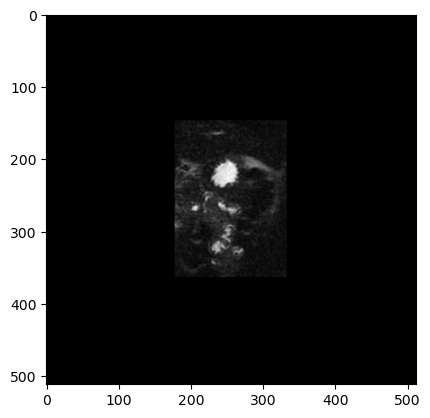

In [31]:
img = X[n,:,:,0]
mask = X[10,:,:,1]
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img, cmap="gray")

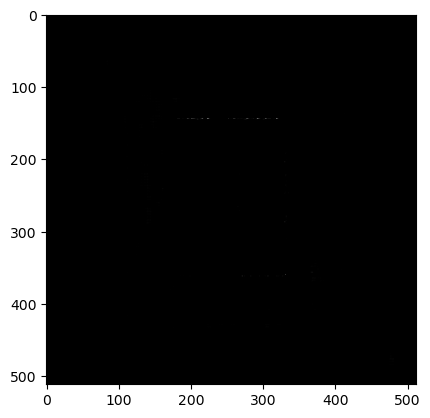

In [32]:
plt.imshow(mask, cmap="gray")

## View output

(512, 512) 197.0 0.0


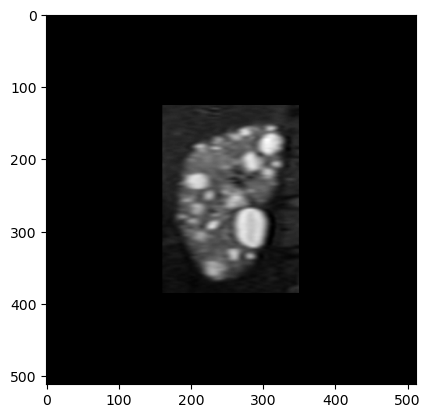

In [30]:
n = 4
X_batch = X[n,:,:,:]
X_batch.shape
X_img = X_batch[:,:,0]
print(X_img.shape, X_img.max(), X_img.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

In [43]:
for s in range(32):
    print(s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


(512, 512) 1.0 1.0


<Figure size 640x480 with 0 Axes>

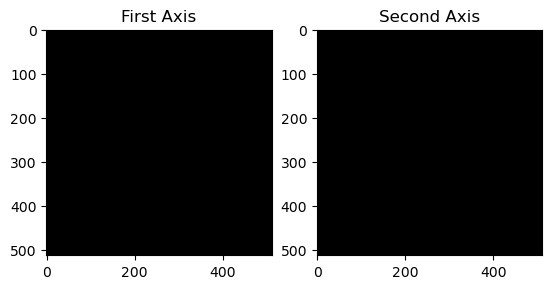

In [32]:
y_batch = y[n,:,:,:]
y_batch.shape
y_img_0 = y_batch[:,:,0]
y_img_1 = y_batch[:,:,1]
print(y_img_0.shape, y_img_0.max(), y_img_0.min())


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_img_0, cmap="gray")
axarr[0].title.set_text('First Axis')
axarr[1].imshow(y_img_1, cmap='gray')
axarr[1].title.set_text('Second Axis')

In [42]:
X1, y1 = training_generator[20]
print(X1.shape)
print(y1.shape)

(32, 512, 512, 1)
(32, 512, 512, 2)


In [43]:
#params = {'dim': (512,512),
         # 'batch_size': 30,
         # 'n_classes': 2,
        #  'n_channels': 1,
        #  'shuffle': True}
#training_generator_2 = DataGenerator(partition['train'], labels, **params)
#validation_generator_2 = DataGenerator(partition['validation'], labels, **params)

In [44]:
model = custom_unet(input_shape=(512,512,1), num_classes=2)
#model.summary()

In [45]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
filepath = "ALL_INSTITUTION_80-10_35ep.h5"
model_name = filepath
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
cb = TimingCallback()

In [46]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [47]:
# Train model on dataset
history = model.fit(training_generator, epochs = 35,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32,callbacks=[cb])

Epoch 1/35
1885/1885 [==============================] - 730s 380ms/step - loss: 0.1876 - dice_coef: 0.9034 - val_loss: 0.0192 - val_dice_coef: 0.9903
Epoch 2/35
1885/1885 [==============================] - 723s 383ms/step - loss: 0.0135 - dice_coef: 0.9932 - val_loss: 0.0075 - val_dice_coef: 0.9962
Epoch 3/35
1885/1885 [==============================] - 725s 384ms/step - loss: 0.0069 - dice_coef: 0.9965 - val_loss: 0.0057 - val_dice_coef: 0.9971
Epoch 4/35
1885/1885 [==============================] - 725s 384ms/step - loss: 0.0053 - dice_coef: 0.9973 - val_loss: 0.0049 - val_dice_coef: 0.9975
Epoch 5/35
1885/1885 [==============================] - 725s 384ms/step - loss: 0.0045 - dice_coef: 0.9977 - val_loss: 0.0048 - val_dice_coef: 0.9975
Epoch 6/35
1885/1885 [==============================] - 734s 389ms/step - loss: 0.0040 - dice_coef: 0.9979 - val_loss: 0.0049 - val_dice_coef: 0.9975
Epoch 7/35
1885/1885 [==============================] - 733s 388ms/step - loss: 0.0037 - dice_coef: 

In [48]:
from keras.models import Sequential, load_model
model.save(model_name)   

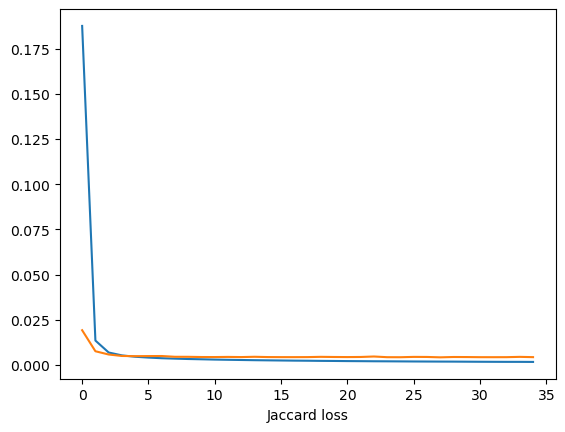

In [49]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

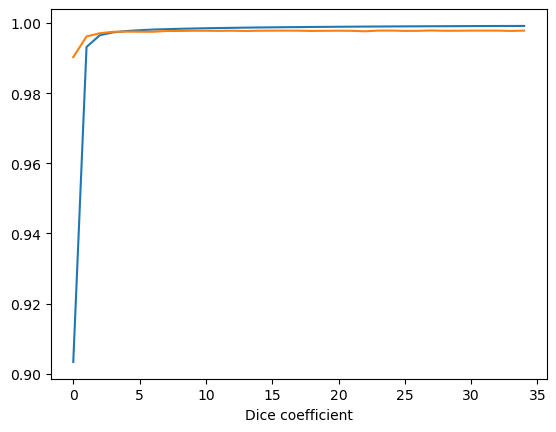

In [50]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [51]:
print(sum(cb.logs)/3600)
import pandas as pd
df = pd.DataFrame.from_dict(history.history)

7.044031654166665


In [52]:
df['epoch_time'] = np.array(cb.logs)
df.to_csv('cyst_seg_80-10_split_35epoch.csv')